<a href="https://colab.research.google.com/github/SLKS99/Exploring-the-Evolution-of-Metal-Halide-Perovskites-via-Latent-Representations-of-the-Photoluminesce/blob/main/4_12_23_SHAP_CsPbBr3_Intensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from sklearn.neural_network import MLPRegressor
import sklearn


import time



from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Data Information

#Name of files 
data_file_name = 'CsPbBr3 Intensity.csv' #@param {type:'string'}
composition_file_name = 'CsPbBr3 wells.csv' #@param {type:'string'}

#Download the correct data
data_file = '1WLx_cNspwZAgmmKkeXK2LJRo8bot5CqJ' #@param {type:"string"}
composition_file = '1inVFp-FtwBxsHCaDJRrarAAshRtmyFV6' #@param {type:"string"}

In [ ]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1WLx_cNspwZAgmmKkeXK2LJRo8bot5CqJ
To: /content/CsPbBr3 Intensity.csv
100% 6.70k/6.70k [00:00<00:00, 7.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1inVFp-FtwBxsHCaDJRrarAAshRtmyFV6
To: /content/CsPbBr3 wells.csv
100% 1.08k/1.08k [00:00<00:00, 1.71MB/s]


In [ ]:
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.titleweight']='bold'

In [ ]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name)

composition = pd.read_csv(composition_file_name, index_col = 0)

display(rawData)

,OAc,OLAm,PbBr2,Cs,Ligand Ratio,OctAc,OctAm,Toluene,Chloroform,Output
0,100,10,300,100,11,0,0,100,0,31475.369690
1,100,20,300,100,12,0,0,100,0,37704.886850
2,100,30,300,100,13,0,0,100,0,52282.362880
3,100,40,300,100,14,0,0,100,0,35474.305960
4,100,50,300,100,15,0,0,100,0,20460.492450
...,...,...,...,...,...,...,...,...,...,...
155,100,160,200,100,26,0,0,0,100,10018.092620
156,100,170,200,100,27,0,0,0,100,9270.016774
157,100,180,200,100,28,0,0,0,100,11848.666250
158,100,190,200,100,29,0,0,0,100,10537.687680


In [ ]:
X = rawData.iloc[:,:-1]
Y = rawData.iloc[:,-1]

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


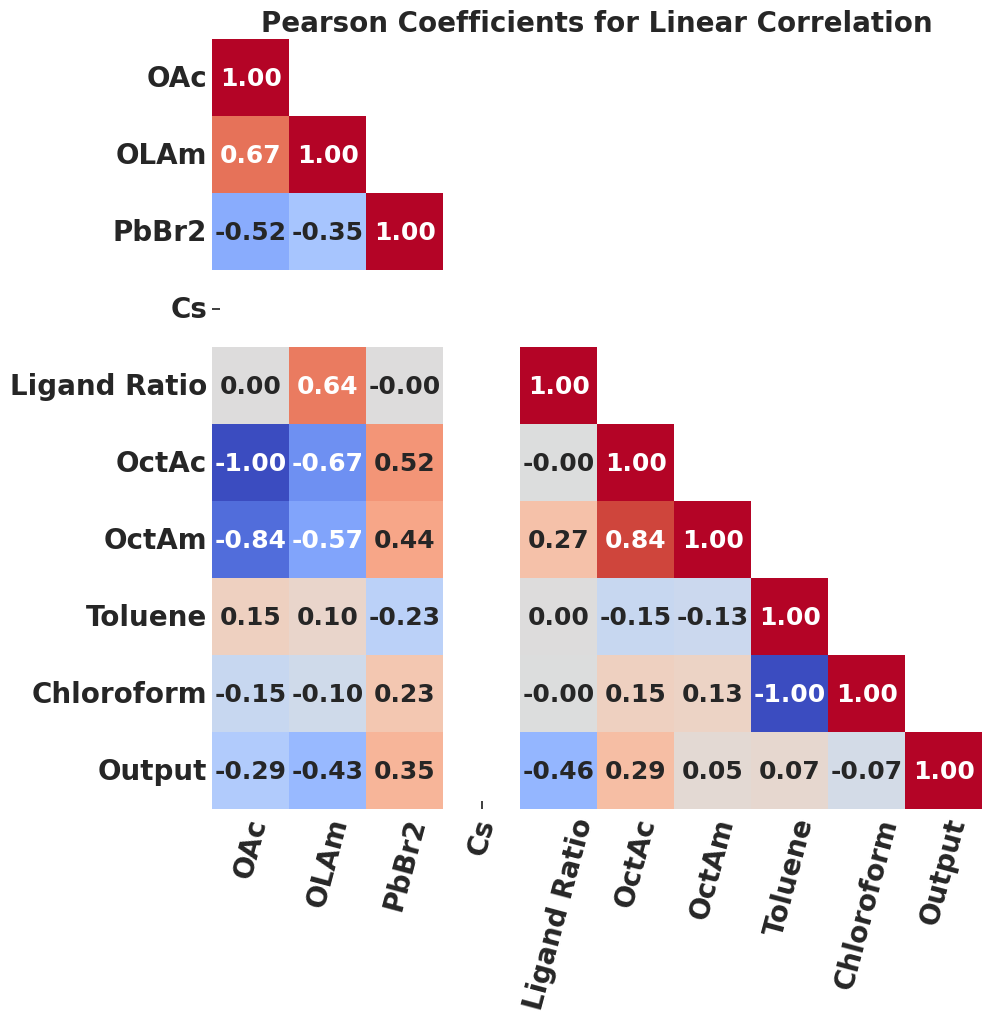

In [ ]:
# Correlation coefficient matrix
corr = rawData.corr(method='pearson')
corr.columns = rawData.columns
rawData_len = len(rawData.columns)
fs = 20
fig, ax=plt.subplots(figsize=(rawData_len,rawData_len))
sns.set(font_scale=1.5)
sns.set_style("ticks",{'xtick.direction': 'in', # set the style of the plot using seaborn
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})
mask = np.triu(np.ones_like(corr, dtype=np.bool),k=1)
cmap = plt.get_cmap('coolwarm')
sns.heatmap(corr,  cbar_kws={"shrink": .2}, annot=True, fmt='.2f', 
            cmap=cmap, cbar=False, ax=ax, square=True,mask=mask)

ax.set_title("Pearson Coefficients for Linear Correlation", fontsize = 20)
plt.xticks(rotation=75, fontsize = fs)
plt.yticks(rotation=0, fontsize = fs) 
plt.show()

In [ ]:
Y

0      31475.369690
1      37704.886850
2      52282.362880
3      35474.305960
4      20460.492450
           ...     
155    10018.092620
156     9270.016774
157    11848.666250
158    10537.687680
159    10037.779680
Name: Output, Length: 160, dtype: float64

In [ ]:
scaler=StandardScaler(
)

X_normalized= scaler.fit_transform(X)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# initialize the random forest regression model
rf_model = RandomForestRegressor(random_state=42)

# perform grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding RMSE score
print("Best Hyperparameters: ", grid_search.best_params_)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, grid_search.predict(X_test))))

Best Hyperparameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE:  9936.90867433229


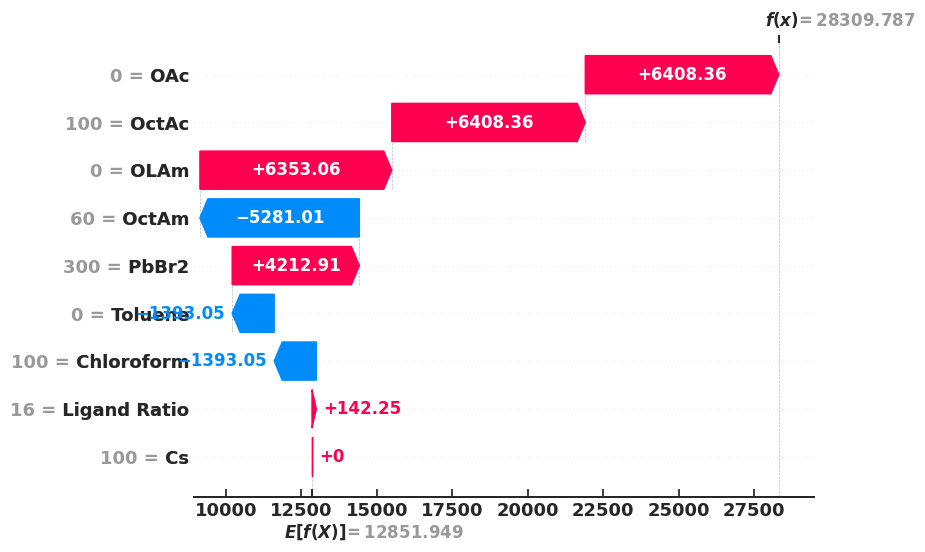

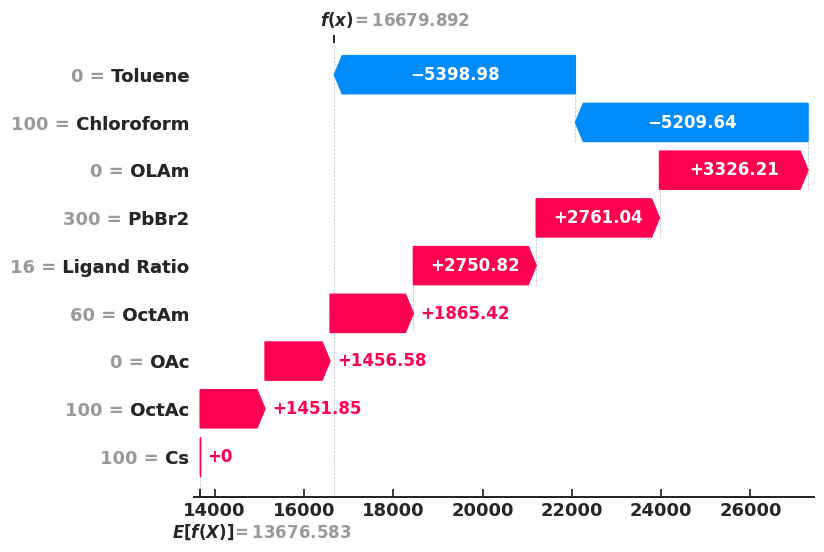

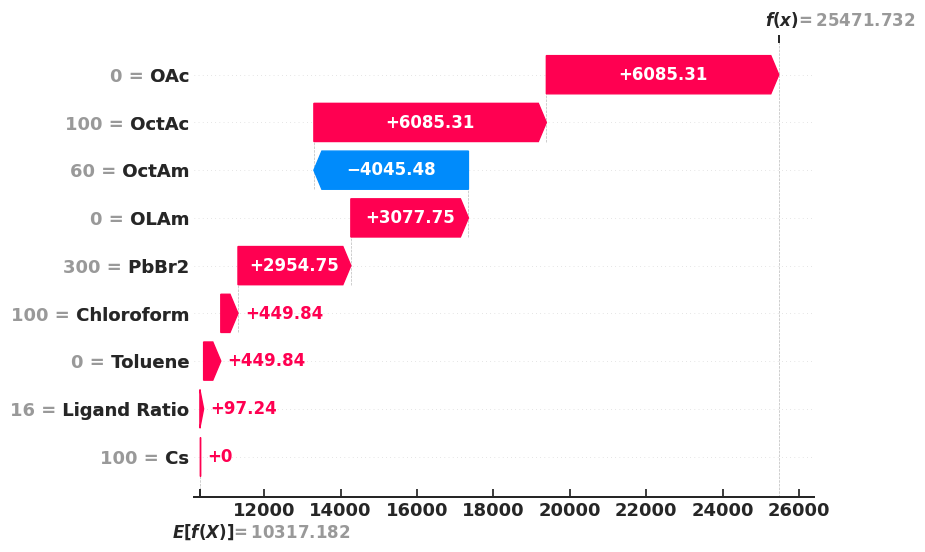

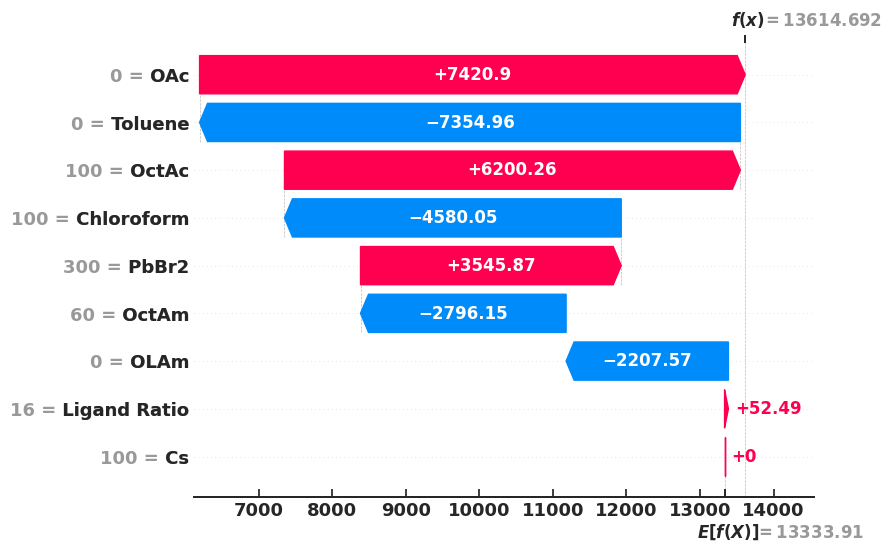

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the six machine learning models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 1, max_depth= 10,max_features= 'sqrt')
svm_reg = SVR(kernel='linear')
nn_reg = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42)


# Train the six models on the training data
lin_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)
svm_reg.fit(X_train, y_train)
nn_reg.fit(X_train, y_train)


# Calculate SHAP values for the test data using each model
explainer_lin_reg = shap.Explainer(lin_reg.predict, X_train)
shap_values_lin_reg = explainer_lin_reg(X_test)

explainer_rf_reg = shap.Explainer(rf_reg.predict, X_train)
shap_values_rf_reg = explainer_rf_reg(X_test)

explainer_svm_reg = shap.Explainer(svm_reg.predict, X_train)
shap_values_svm_reg = explainer_svm_reg(X_test)

explainer_nn_reg = shap.Explainer(nn_reg.predict, X_train)
shap_values_nn_reg = explainer_nn_reg(X_test)



# Plot the SHAP values for a single example
shap.plots.waterfall(shap_values_lin_reg[0])
shap.plots.waterfall(shap_values_rf_reg[0])
shap.plots.waterfall(shap_values_svm_reg[0])
shap.plots.waterfall(shap_values_nn_reg[0])



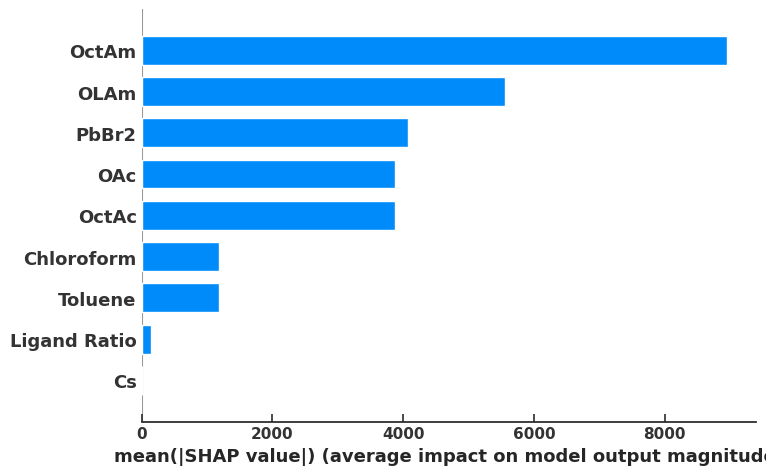

In [ ]:

plt.xlabel('Linear regressor coefficients')
shap.summary_plot(shap_values_lin_reg, X_test, plot_type="bar", show=False)


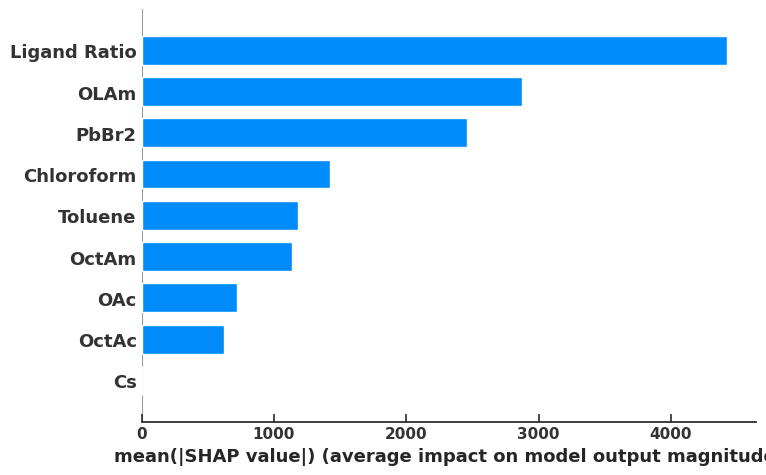

In [ ]:
shap.summary_plot(shap_values_rf_reg, X_test, plot_type="bar", show=False)


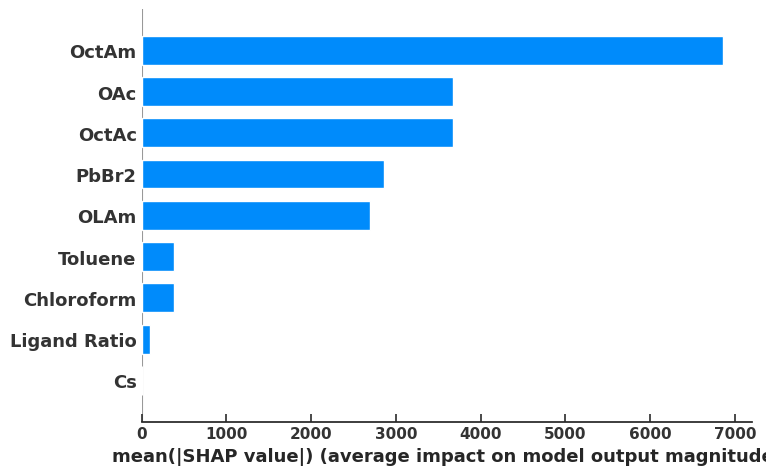

In [ ]:
shap.summary_plot(shap_values_svm_reg, X_test, plot_type="bar", show=False)


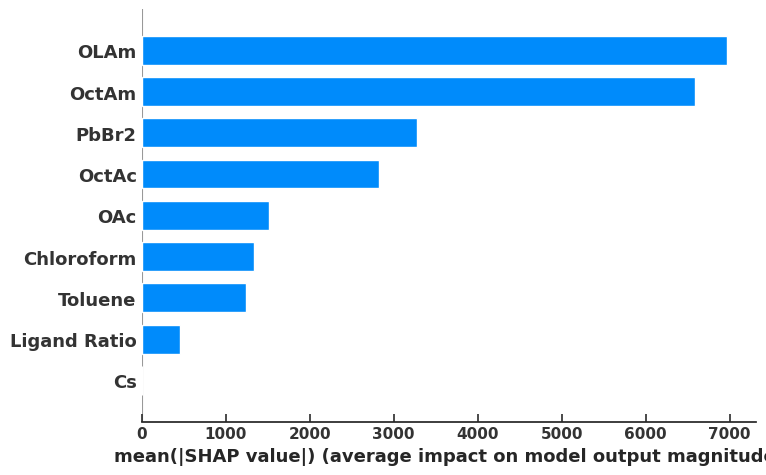

In [ ]:
shap.summary_plot(shap_values_nn_reg, X_test, plot_type="bar", show=False)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


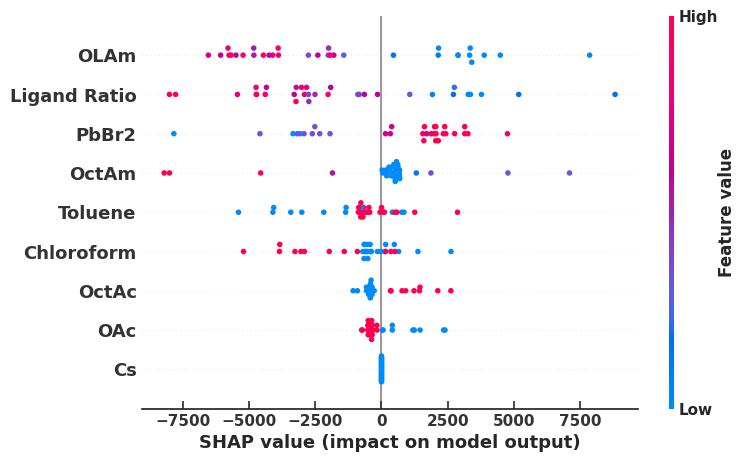

In [ ]:
#shap.plots.beeswarm(shap_values_lin_reg)

shap.plots.beeswarm(shap_values_rf_reg)
plt.show()
#shap.plots.beeswarm(shap_values_svm_reg)
#shap.plots.beeswarm(shap_values_nn_reg)



In [ ]:
import matplotlib


In [ ]:
print(matplotlib.get_cachedir())

/root/.cache/matplotlib


In [ ]:
# Assuming you have already defined your training and testing data X_train, Y_train, X_test, Y_test and model

# Make predictions on the test data
Y_pred =lin_reg .predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, Y_pred, squared=False)

print("Root Mean Squared Error: {}".format(rmse))

# Make predictions on the test data
Y_pred =rf_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))

print("Root Mean Squared Error: {}".format(rmse))
# Make predictions on the test data
Y_pred =lin_reg .predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))

print("Root Mean Squared Error: {}".format(rmse))
# Make predictions on the test data
Y_pred =svm_reg .predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))

print("Root Mean Squared Error: {}".format(rmse))
# Make predictions on the test data
Y_pred =nn_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))

print("Root Mean Squared Error: {}".format(rmse))


Root Mean Squared Error: 13085.31141449012
Root Mean Squared Error: 10056.883476562232
Root Mean Squared Error: 13085.31141449012
Root Mean Squared Error: 11925.217020372575
Root Mean Squared Error: 11115.933189973197


In [ ]:

# Normalize the X data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Convert the normalized X data back to a dataframe with the original feature names
X_norm_df = pd.DataFrame(X_norm, columns=X.columns)


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Exact explainer: 33it [00:18,  1.05it/s]
Exact explainer: 33it [00:18,  1.10s/it]


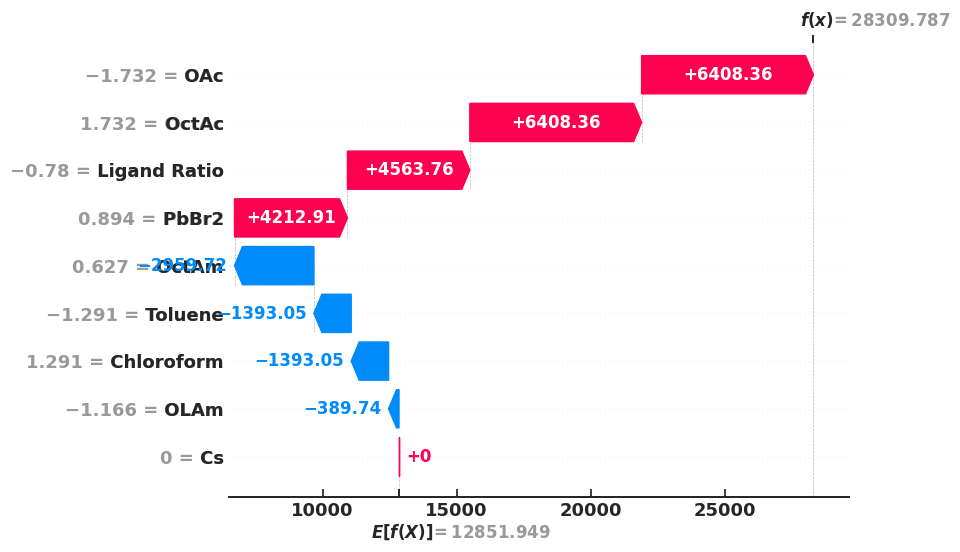

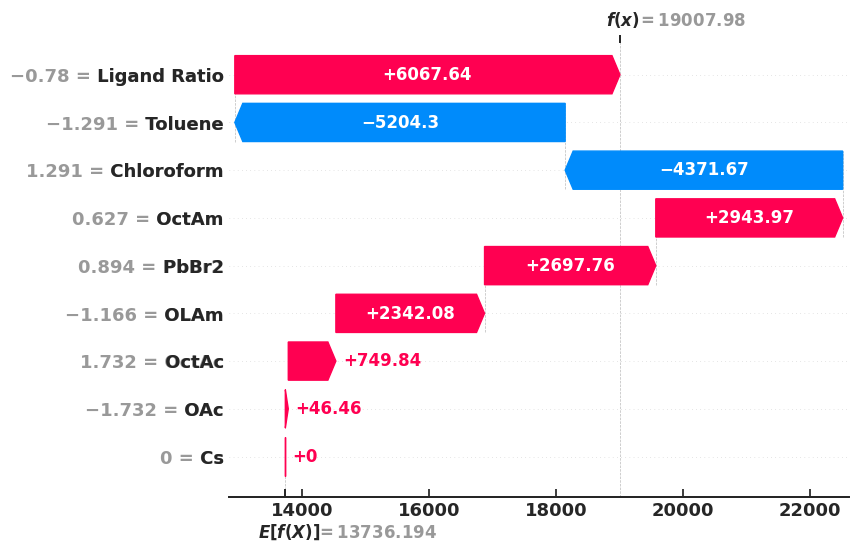

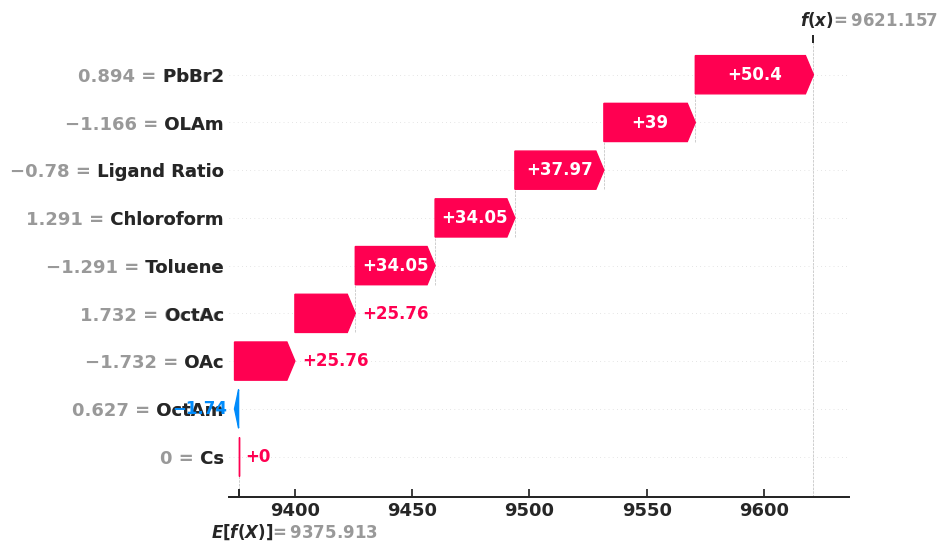

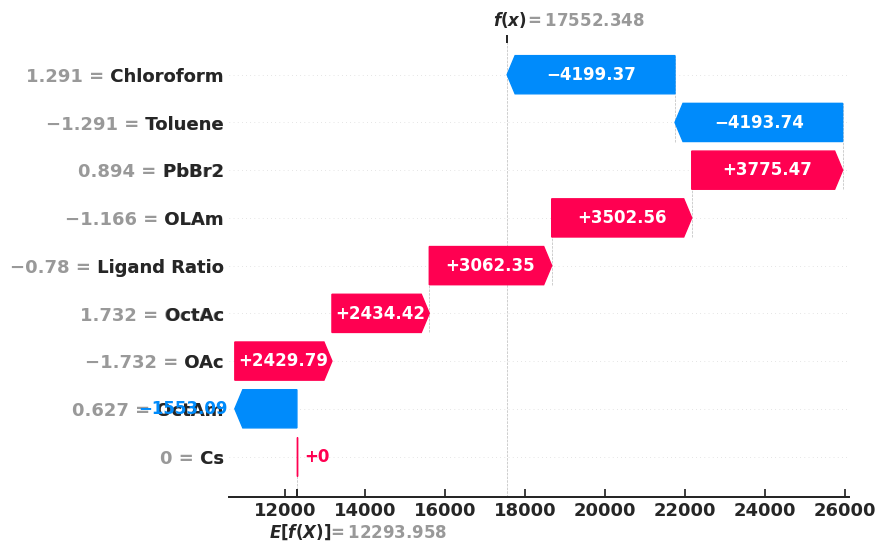

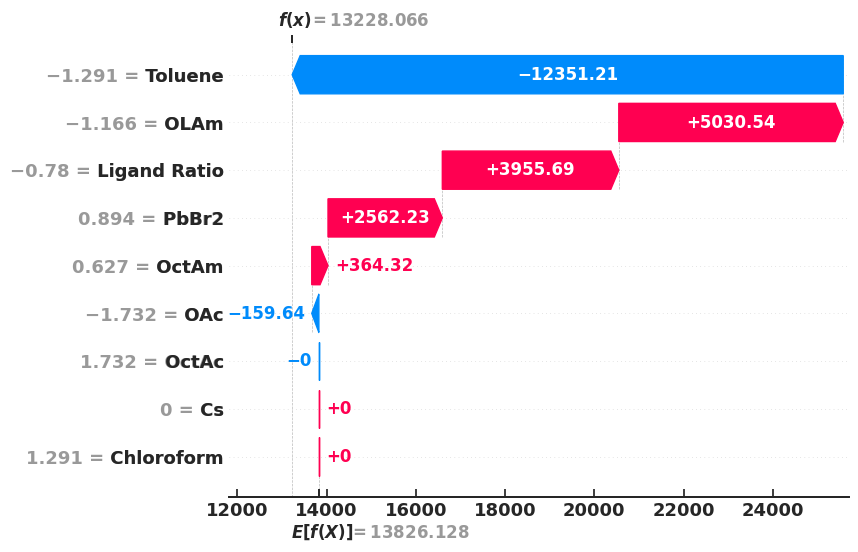

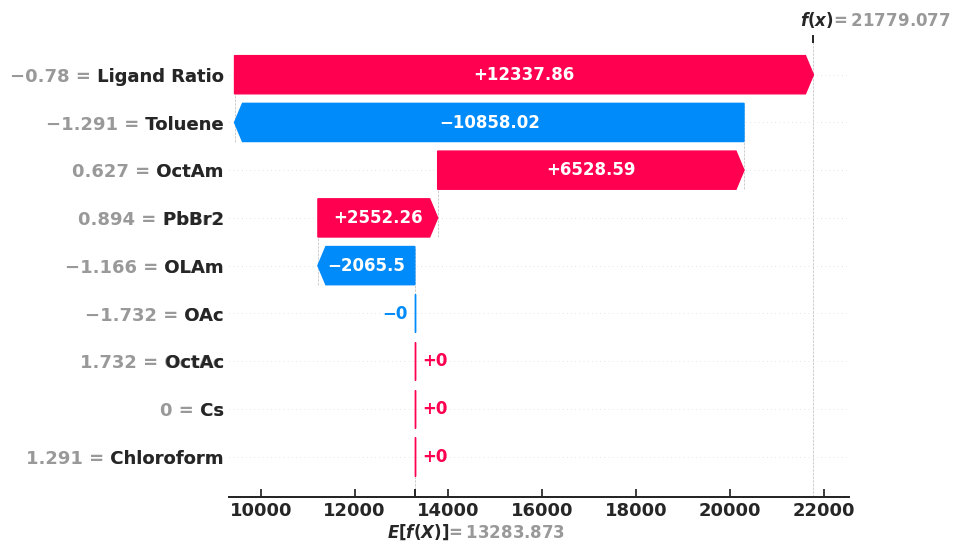

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_norm_df, Y, test_size=0.2, random_state=42)

# Define the six machine learning models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators= 100, min_samples_split= 5, min_samples_leaf= 1, max_depth= 10)
svm_reg = SVR(kernel='linear')
nn_reg = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42)
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=10, random_state=42)
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, max_depth=10, random_state=42)

# Train the six models on the training data
lin_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)
svm_reg.fit(X_train, y_train)
nn_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgb_reg.fit(X_train, y_train)

# Calculate SHAP values for the test data using each model
explainer_lin_reg = shap.Explainer(lin_reg.predict, X_train)
shap_values_lin_reg = explainer_lin_reg(X_test)

explainer_rf_reg = shap.Explainer(rf_reg.predict, X_train)
shap_values_rf_reg = explainer_rf_reg(X_test)

explainer_svm_reg = shap.Explainer(svm_reg.predict, X_train)
shap_values_svm_reg = explainer_svm_reg(X_test)

explainer_nn_reg = shap.Explainer(nn_reg.predict, X_train)
shap_values_nn_reg = explainer_nn_reg(X_test)

explainer_xgb_reg = shap.Explainer(xgb_reg.predict, X_train)
shap_values_xgb_reg = explainer_xgb_reg(X_test)

explainer_lgb_reg = shap.Explainer(lgb_reg.predict, X_train)
shap_values_lgb_reg = explainer_lgb_reg(X_test)

# Plot the SHAP values for a single example
shap.plots.waterfall(shap_values_lin_reg[0])
shap.plots.waterfall(shap_values_rf_reg[0])
shap.plots.waterfall(shap_values_svm_reg[0])
shap.plots.waterfall(shap_values_nn_reg[0])
shap.plots.waterfall(shap_values_xgb_reg[0])
shap.plots.waterfall(shap_values_lgb_reg[0])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


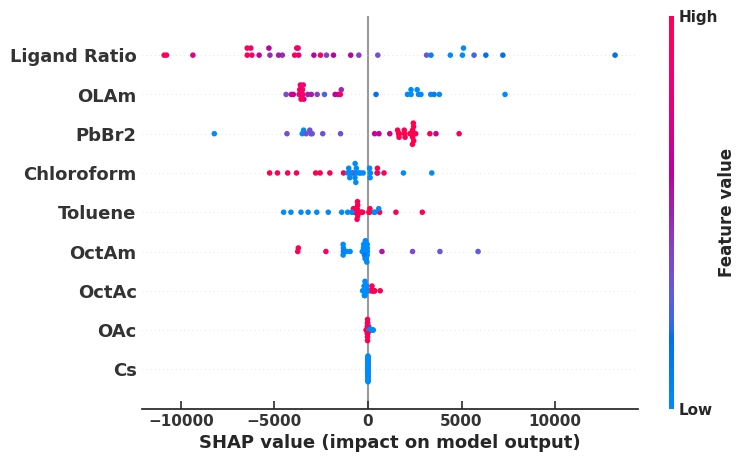

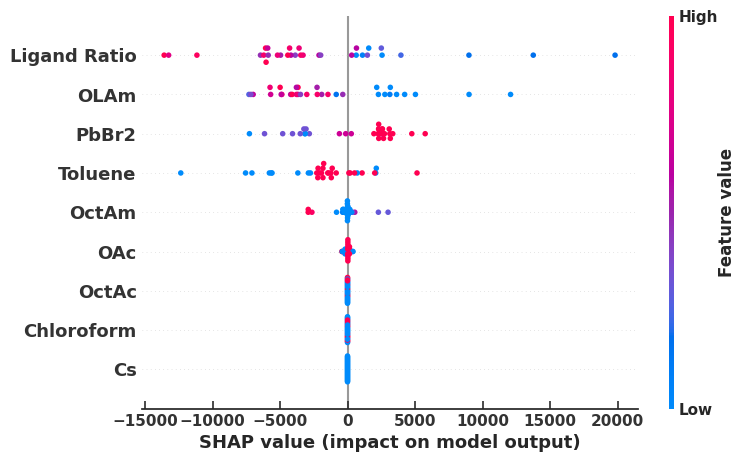

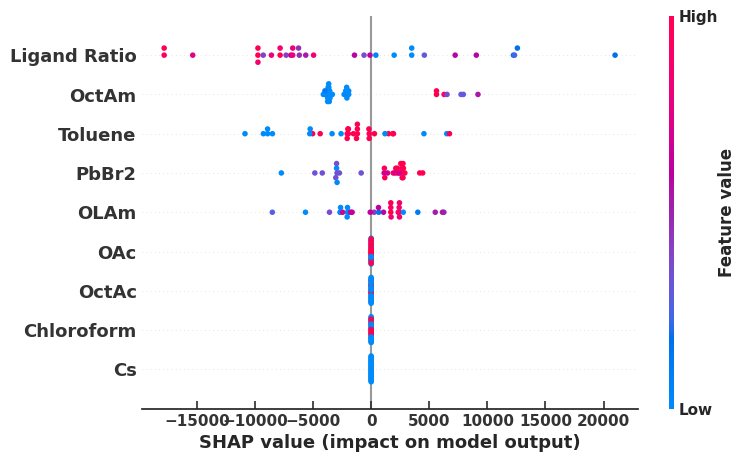

In [ ]:
#shap.plots.beeswarm(shap_values_lin_reg)
shap.plots.beeswarm(shap_values_rf_reg)
#shap.plots.beeswarm(shap_values_svm_reg)
#shap.plots.beeswarm(shap_values_nn_reg)
shap.plots.beeswarm(shap_values_xgb_reg)
shap.plots.beeswarm(shap_values_lgb_reg )

